In [1]:
from sklearn.model_selection import train_test_split
import random
import numpy as np
import matplotlib.pyplot as plt
import pickle


In [2]:
def step_fn_generator(stepLoc=0):
    def f(x):
        ret = np.zeros(len(x))
        ret[x >= stepLoc] = 1
        return ret
    return f

def linear_comb_generator(fns, coefs):
    def f(x):
        return sum(fns[i](x) * coefs[i] for i in range(len(fns)))
    return f

In [3]:
def get_target_and_featurizer(num_basis_fns = 100, num_nonzero = 10, coefs_true=None):
    # We'll create a basis of step functions on the interval [0,1]. We'll then
    # construct a linear combination of these step functions to be our target
    # function. We'll construct a function to "featurize" an input in [0,1]
    # into the evaluations of all functions in the basis on the input.
    # Optionally: If coefs_true is provided, they will be used to generate
    # target_fn and featurize.
    # Construct basis, to be used for generating target function

    if coefs_true is not None:
        num_basis_fns = len(coefs_true)
    else:
        nonzero_indices = np.random.choice(num_basis_fns, num_nonzero)
        coefs_true = np.zeros(num_basis_fns)
        coefs_true[nonzero_indices] = np.random.randn(num_nonzero)

    all_basis_fns = [step_fn_generator(stepLoc=s)
                     for s in np.linspace(0, 1, num_basis_fns, endpoint=False)]

    # Construct target function (the Bayes prediction function)
    target_fn = linear_comb_generator(all_basis_fns, coefs_true)

    def featurize(x):
        n = len(x)
        # Featurize input values in [0,1]
        X_ftrs = np.empty((n, num_basis_fns))
        for ftr_num in range(num_basis_fns):
            X_ftrs[:, ftr_num] = all_basis_fns[ftr_num](x)
        return X_ftrs

    return target_fn, coefs_true, featurize


In [4]:
def generate_data(target_fn, n=1000, noise_scale=.25, tdof=6):
    # Construct dataset
    x = np.sort(np.random.rand(n)) #chooses uniformly from [0,1)
    y_target = target_fn(x)
    y = y_target + noise_scale * np.random.standard_t(tdof,n)
    return x, y

def get_data_splits(x, y, test_frac=.2):
    ## Based on https://github.com/ageron/handson-ml/blob/master/02_end_to_end_machine_learning_project.ipynb
    n = len(y)
    shuffled_indices = np.random.permutation(n)
    n_test = int(n * test_frac)
    n_train = n - n_test
    indices_test = shuffled_indices[:n_test]
    indices_train = shuffled_indices[n_test:]
    y_train = y[indices_train]
    x_train = x[indices_train]
    y_test = y[indices_test]
    x_test = x[indices_test]
    return x_train, y_train, x_test, y_test

def generate_problem(n=200, num_basis_fns=400, num_nonzero=10, noise_scale=.25, tdof=6, test_frac=.2, write_problem=False, file_name="lasso_data.pickle"):
    target_fn, coefs_true, featurize = get_target_and_featurizer(num_basis_fns, num_nonzero)
    x, y = generate_data(target_fn, n, noise_scale, tdof)
    x_train, y_train, x_test, y_test = get_data_splits(x, y, test_frac)

    if write_problem:
        print ("Saving problem to disk.")
        data = {"coefs_true":coefs_true, "x_train":x_train,
                "y_train":np.copy(y_train), "x_test":x_test, "y_test":y_test}
        with open(file_name, 'wb') as outfile:
            pickle.dump(data, outfile, protocol=2)

    return x_train, y_train, x_test, y_test, target_fn, coefs_true, featurize

def reconstitute_problem(coefs_true, x_train, y_train, x_test, y_test):
    target_fn, coefs_true, featurize = get_target_and_featurizer(coefs_true=coefs_true)
    return x_train, y_train, x_test, y_test, target_fn, coefs_true, featurize

def load_problem(file_name):
    f_myfile = open(file_name, 'rb')
    data = pickle.load(f_myfile)
    f_myfile.close()
    return reconstitute_problem(data["coefs_true"], data["x_train"], data["y_train"],
                                data["x_test"], data["y_test"])

def main():
    lasso_data_fname = "lasso_data.pickle"
    LOAD_PROBLEM=True
    GENERATE_PROBLEM=False
    WRITE_PROBLEM=False
    if GENERATE_PROBLEM:
        n=1000
        test_frac=.9
        num_basis_fns=400
        num_nonzero=10
        noise_scale=.25 # scale factor on noise
        tdof = 6 # degrees of freedom of t-distribution generating noise
        x_train, y_train, x_val, y_val, target_fn, coefs_true, featurize = generate_problem(n=n, num_basis_fns=num_basis_fns, num_nonzero=num_nonzero, noise_scale=noise_scale, test_frac=test_frac, write_problem=WRITE_PROBLEM, file_name=lasso_data_fname)

    if LOAD_PROBLEM:
        x_train, y_train, x_val, y_val, target_fn, coefs_true, featurize = load_problem(lasso_data_fname)

    # Let's plot the target function (i.e. the Bayes prediction function) as
    # well as the noisy observations from the training data, as a function of
    # the original input space, which is the interval [0,1).
    fig, ax = plt.subplots()
    plt.scatter(x_train, y_train, s=3, color='k', label='Training data')
    x = np.arange(0,1,.001)
    ax.plot(x, target_fn(x), 'r', label='Target function (i.e. Bayes prediction function)')
    legend = ax.legend(loc='upper center', shadow=True)
    plt.show(block=False)


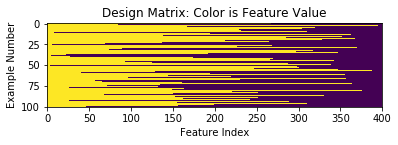

Hoping this is very close to 0:4.6937824306758424e-11
    param_l2reg  mean_test_score  mean_train_score
0      0.000001         0.172579          0.006752
1      0.000010         0.172464          0.006752
2      0.000100         0.171345          0.006774
3      0.001000         0.162705          0.008285
4      0.010000         0.141887          0.032767
5      0.100000         0.144566          0.094953
6      1.000000         0.171068          0.197694
7      1.300000         0.179521          0.216591
8      1.600000         0.187993          0.233450
9      1.900000         0.196361          0.248803
10     2.200000         0.204553          0.262958
11     2.500000         0.212530          0.276116
12     2.800000         0.220271          0.288422


/Users/zhangben/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


In [5]:
"""
Ridge regression using scipy's minimize function and demonstrating the use of
sklearn's framework.

Author: David S. Rosenberg <david.davidr@gmail.com>
License: Creative Commons Attribution 4.0 International License
"""
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, make_scorer
import pandas as pd

from setup_problem import load_problem

class RidgeRegression(BaseEstimator, RegressorMixin):
    """ ridge regression"""

    def __init__(self, l2reg=1):
        if l2reg < 0:
            raise ValueError('Regularization penalty should be at least 0.')
        self.l2reg = l2reg

    def fit(self, X, y=None):
        n, num_ftrs = X.shape
        # convert y to 1-dim array, in case we're given a column vector
        y = y.reshape(-1)
        def ridge_obj(w):
            predictions = np.dot(X,w)
            residual = y - predictions
            empirical_risk = np.sum(residual**2) / n
            l2_norm_squared = np.sum(w**2)
            objective = empirical_risk + self.l2reg * l2_norm_squared
            return objective
        self.ridge_obj_ = ridge_obj

        w_0 = np.zeros(num_ftrs)
        self.w_ = minimize(ridge_obj, w_0).x
        return self

    def predict(self, X, y=None):
        try:
            getattr(self, "w_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")
        return np.dot(X, self.w_)

    def score(self, X, y):
        # Average square error
        try:
            getattr(self, "w_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")
        residuals = self.predict(X) - y
        return np.dot(residuals, residuals)/len(y)



def compare_our_ridge_with_sklearn(X_train, y_train, l2_reg=1):
    # First run sklearn ridge regression and extract the coefficients
    from sklearn.linear_model import Ridge
    # Fit with sklearn -- need to multiply l2_reg by sample size, since their
    # objective function has the total square loss, rather than average square
    # loss.
    n = X_train.shape[0]
    sklearn_ridge = Ridge(alpha=n*l2_reg, fit_intercept=False, normalize=False)
    sklearn_ridge.fit(X_train, y_train)
    sklearn_ridge_coefs = sklearn_ridge.coef_

    # Now run our ridge regression and compare the coefficients to sklearn's
    ridge_regression_estimator = RidgeRegression(l2reg=l2_reg)
    ridge_regression_estimator.fit(X_train, y_train)
    our_coefs = ridge_regression_estimator.w_

    print("Hoping this is very close to 0:{}".format(np.sum((our_coefs - sklearn_ridge_coefs)**2)))

def do_grid_search_ridge(X_train, y_train, X_val, y_val):
    # Now let's use sklearn to help us do hyperparameter tuning
    # GridSearchCv.fit by default splits the data into training and
    # validation itself; we want to use our own splits, so we need to stack our
    # training and validation sets together, and supply an index
    # (validation_fold) to specify which entries are train and which are
    # validation.
    X_train_val = np.vstack((X_train, X_val))
    y_train_val = np.concatenate((y_train, y_val))
    val_fold = [-1]*len(X_train) + [0]*len(X_val) #0 corresponds to validation

    # Now we set up and do the grid search over l2reg. The np.concatenate
    # command illustrates my search for the best hyperparameter. In each line,
    # I'm zooming in to a particular hyperparameter range that showed promise
    # in the previous grid. This approach works reasonably well when
    # performance is convex as a function of the hyperparameter, which it seems
    # to be here.
    param_grid = [{'l2reg':np.unique(np.concatenate((10.**np.arange(-6,1,1),
                                           np.arange(1,3,.3)
                                             ))) }]

    ridge_regression_estimator = RidgeRegression() #?????ridge_regression_estimator???r 
    grid = GridSearchCV(ridge_regression_estimator,
                        param_grid,
                        return_train_score=True,
                        cv = PredefinedSplit(test_fold=val_fold),
                        refit = True,
                        scoring = make_scorer(mean_squared_error,
                                              greater_is_better = False))
    grid.fit(X_train_val, y_train_val)

    df = pd.DataFrame(grid.cv_results_)
    # Flip sign of score back, because GridSearchCV likes to maximize,
    # so it flips the sign of the score if "greater_is_better=FALSE"
    df['mean_test_score'] = -df['mean_test_score']
    df['mean_train_score'] = -df['mean_train_score']
    cols_to_keep = ["param_l2reg", "mean_test_score","mean_train_score"]
    df_toshow = df[cols_to_keep].fillna('-')
    df_toshow = df_toshow.sort_values(by=["param_l2reg"])
    return grid, df_toshow

def compare_parameter_vectors(pred_fns):
    # Assumes pred_fns is a list of dicts, and each dict has a "name" key and a
    # "coefs" key
    fig, axs = plt.subplots(len(pred_fns),1, sharex=True)
    num_ftrs = len(pred_fns[0]["coefs"])
    for i in range(len(pred_fns)):
        title = pred_fns[i]["name"]
        coef_vals = pred_fns[i]["coefs"]
        axs[i].bar(range(num_ftrs), coef_vals)
        axs[i].set_xlabel('Feature Index')
        axs[i].set_ylabel('Parameter Value')
        axs[i].set_title(title)

    fig.subplots_adjust(hspace=0.3)
    return fig

def plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best"):
    # Assumes pred_fns is a list of dicts, and each dict has a "name" key and a
    # "preds" key. The value corresponding to the "preds" key is an array of
    # predictions corresponding to the input vector x. x_train and y_train are
    # the input and output values for the training data
    fig, ax = plt.subplots()
    ax.set_xlabel('Input Space: [0,1)')
    ax.set_ylabel('Action/Outcome Space')
    ax.set_title("Prediction Functions")
    plt.scatter(x_train, y_train, label='Training data')
    for i in range(len(pred_fns)):
        ax.plot(x, pred_fns[i]["preds"], label=pred_fns[i]["name"])
    legend = ax.legend(loc=legend_loc, shadow=True)
    return fig

def main():
    lasso_data_fname = "lasso_data.pickle"
    x_train, y_train, x_val, y_val, target_fn, coefs_true, featurize = load_problem(lasso_data_fname)

    # Generate features
    X_train = featurize(x_train)
    X_val = featurize(x_val)

    #Visualize training data
    fig, ax = plt.subplots()
    ax.imshow(X_train)
    ax.set_title("Design Matrix: Color is Feature Value")
    ax.set_xlabel("Feature Index")
    ax.set_ylabel("Example Number")
    plt.show(block=False)

    # Compare our RidgeRegression to sklearn's.
    compare_our_ridge_with_sklearn(X_train, y_train, l2_reg = 1.5)

    # Do hyperparameter tuning with our ridge regression
    grid, results = do_grid_search_ridge(X_train, y_train, X_val, y_val)
    print(results)

    # Plot validation performance vs regularization parameter
    fig, ax = plt.subplots()
#    ax.loglog(results["param_l2reg"], results["mean_test_score"])
    ax.semilogx(results["param_l2reg"], results["mean_test_score"])
    ax.grid()
    ax.set_title("Validation Performance vs L2 Regularization")
    ax.set_xlabel("L2-Penalty Regularization Parameter")
    ax.set_ylabel("Mean Squared Error")
    fig.show()

    # Let's plot prediction functions and compare coefficients for several fits
    # and the target function.
    pred_fns = []
    x = np.sort(np.concatenate([np.arange(0,1,.001), x_train]))
    name = "Target Parameter Values (i.e. Bayes Optimal)"
    pred_fns.append({"name":name, "coefs":coefs_true, "preds": target_fn(x) })

    l2regs = [0, grid.best_params_['l2reg'], 1]
    X = featurize(x)
    for l2reg in l2regs:
        ridge_regression_estimator = RidgeRegression(l2reg=l2reg)
        ridge_regression_estimator.fit(X_train, y_train)
        name = "Ridge with L2Reg="+str(l2reg)
        pred_fns.append({"name":name,
                         "coefs":ridge_regression_estimator.w_,
                         "preds": ridge_regression_estimator.predict(X) })

    f = plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best")
    f.show()

    f = compare_parameter_vectors(pred_fns)
    f.show()

if __name__ == '__main__':
  main()


## 2.1

In [14]:
lasso_data_fname = "lasso_data.pickle"
x_train, y_train, x_val, y_val, target_fn, coefs_true, featurize = load_problem(lasso_data_fname)

# Generate features
X_train = featurize(x_train)
X_val = featurize(x_val)

In [15]:
grid, results = do_grid_search_ridge(X_train, y_train, X_val, y_val)
print(results)

    param_l2reg  mean_test_score  mean_train_score
0      0.000001         0.172579          0.006752
1      0.000010         0.172464          0.006752
2      0.000100         0.171345          0.006774
3      0.001000         0.162705          0.008285
4      0.010000         0.141887          0.032767
5      0.100000         0.144566          0.094953
6      1.000000         0.171068          0.197694
7      1.300000         0.179521          0.216591
8      1.600000         0.187993          0.233450
9      1.900000         0.196361          0.248803
10     2.200000         0.204553          0.262958
11     2.500000         0.212530          0.276116
12     2.800000         0.220271          0.288422


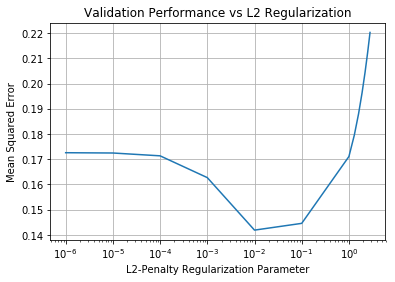

In [17]:
fig, ax = plt.subplots()
#    ax.loglog(results["param_l2reg"], results["mean_test_score"])
ax.semilogx(results["param_l2reg"], results["mean_test_score"])
ax.grid()
ax.set_title("Validation Performance vs L2 Regularization") 
ax.set_xlabel("L2-Penalty Regularization Parameter")
ax.set_ylabel("Mean Squared Error")
plt.show()

## 2.2

In [102]:
def plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best"):
    # Assumes pred_fns is a list of dicts, and each dict has a "name" key and a
    # "preds" key. The value corresponding to the "preds" key is an array of
    # predictions corresponding to the input vector x. x_train and y_train are
    # the input and output values for the training data
    fig, ax = plt.subplots(figsize = (12, 9))
    ax.set_xlabel('Input Space: [0,1)')
    ax.set_ylabel('Action/Outcome Space')
    ax.set_title("Prediction Functions")
    plt.scatter(x_train, y_train, label='Training data')
    for i in range(len(pred_fns)):
        ax.plot(x, pred_fns[i]["preds"], label=pred_fns[i]["name"])
    legend = ax.legend(loc=legend_loc, shadow=True)
    return fig

pred_fns = []
x = np.sort(np.concatenate([np.arange(0,1,.001), x_train]))
name = "Target Parameter Values (i.e. Bayes Optimal)"
pred_fns.append({"name":name, "coefs":coefs_true, "preds": target_fn(x) })

l2regs = [0, grid.best_params_['l2reg']]
X = featurize(x)
for l2reg in l2regs:
    ridge_regression_estimator = RidgeRegression(l2reg=l2reg)
    ridge_regression_estimator.fit(X_train, y_train)
    name = "Ridge with L2Reg="+str(l2reg)
    pred_fns.append({"name":name,
                     "coefs":ridge_regression_estimator.w_,
                     "preds": ridge_regression_estimator.predict(X) })


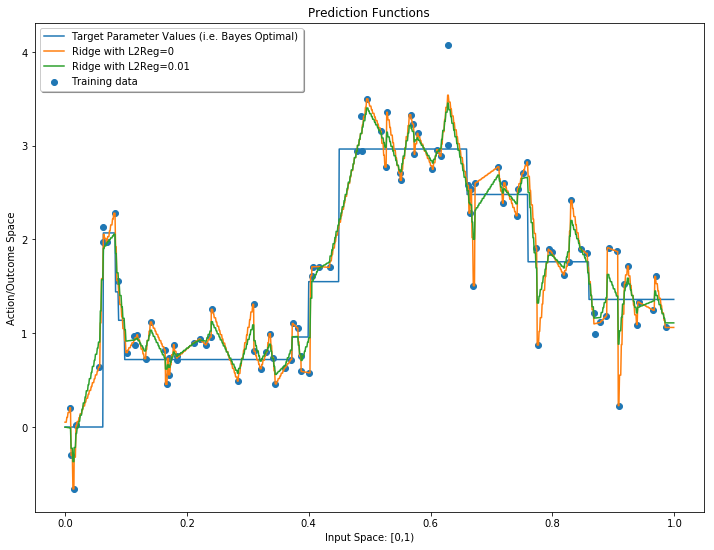

In [103]:
f = plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best")
plt.show()

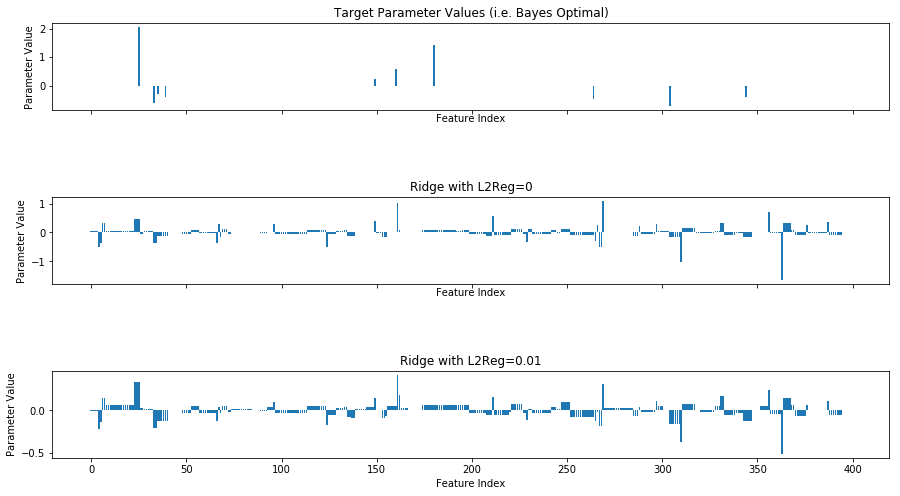

In [107]:
def compare_parameter_vectors(pred_fns):
    # Assumes pred_fns is a list of dicts, and each dict has a "name" key and a
    # "coefs" key
    fig, axs = plt.subplots(len(pred_fns),1, figsize = (15, 8),sharex=True)
    num_ftrs = len(pred_fns[0]["coefs"])
    for i in range(len(pred_fns)):
        title = pred_fns[i]["name"]
        coef_vals = pred_fns[i]["coefs"]
        axs[i].bar(range(num_ftrs), coef_vals)
        axs[i].set_xlabel('Feature Index')
        axs[i].set_ylabel('Parameter Value')
        axs[i].set_title(title)

    fig.subplots_adjust(hspace=1)
    return fig



f = compare_parameter_vectors(pred_fns)
plt.show()


Describe the patterns,
including the scale of the coefficients, as well as which coefficients have the most weight.

## 2.3

In [165]:
pred_fns_best = []
x = np.sort(np.concatenate([np.arange(0,1,.001), x_train]))
# name = "Target Parameter Values (i.e. Bayes Optimal)"
# pred_fns.append({"name":name, "coefs":coefs_true, "preds": target_fn(x) })

l2regs = [grid.best_params_['l2reg']]
X = featurize(x)
for l2reg in l2regs:
    ridge_regression_estimator = RidgeRegression(l2reg=l2reg)
    ridge_regression_estimator.fit(X_train, y_train)
    name = "Ridge with L2Reg="+str(l2reg)
    pred_fns_best.append({"name":name,
                     "coefs":ridge_regression_estimator.w_,
                     "preds": ridge_regression_estimator.predict(X) })



In [180]:
from sklearn.metrics import confusion_matrix
true_w = coefs_true.copy()
for i in range(true_w.shape[0]):
        if true_w[i] != 0:
            true_w[i] = 1
        else:
            true_w[i] = 0
          
elist = [1e-6,1e-3,1e-1] 
for e in elist:
    pred_w = ridge_regression_estimator.w_.copy()
    for i in range(pred_w.shape[0]):
        if np.absolute(pred_w[i]) < e:
            pred_w[i] = 0
        else:
            pred_w[i] = 1        
    print(confusion_matrix(true_w, pred_w)) 


[[  5 385]
 [  0  10]]
[[  8 382]
 [  0  10]]
[[349  41]
 [  3   7]]


## 3.1.2

In [127]:
def Lasso_obj(X, y, w, lambda_reg):
    residual = np.dot(X, w) - y
    empirical_risk = np.sum(residual**2)
    l1_norm = np.linalg.norm(w, ord=1)
    objective = empirical_risk + lambda_reg * l1_norm
    return objective

In [128]:
def soft(a,b):
    if a > 0:
        sign_a = 1
    else:
        sign_a = -1
    wnew = sign_a * max(np.abs(a)-b, 0)
    return wnew

In [578]:
def Lassodescent(X, y, w_choice, method, lambda_reg=0.01, num_iter=1000):
    (num_instances, num_features) = X.shape
    if w_choice == "Murphy":
        I = np.diag(np.ones(X.shape[1]))
        w = inv(np.dot(X.T,X)+ lambda_reg*I).dot(X.T).dot(y)
    else:
        w = np.zeros(num_features)
     
    w_next = np.zeros(num_features) 
    w_hist = np.zeros((num_iter+1, num_features))  #Initialize w_hist
    w_hist[0] = w
    obj_hist = np.zeros(num_iter+1) #Initialize loss_hist
    objforplot_hist = np.zeros(num_iter+1) #Initialize loss_hist
    
    if method == "Cyclic":
        for i in range(num_iter):
            obj_hist[i] = Lasso_obj(X, y, w.T, lambda_reg)
            objforplot_hist[i] = obj_hist[i]/num_instances

            for j in range(num_features):

                a = (2*X[:,j].T).dot(X[:,j])
                c = (2*X[:,j]).dot(y - X.dot(w.T) + w[j]*X[:,j])
                if a==0:
                    w_next[j]=0
                else:
                    w_next[j] = soft(c/a,lambda_reg/a)
                w[j] = w_next[j]
            
            w_hist[i+1] = w

            if (obj_hist[i+1]-obj_hist[i])<1e-8:
                break 

            
    else:
        l=list(range(num_features))     
        for i in range(num_iter):
            obj_hist[i] = Lasso_obj(X, y, w.T, lambda_reg)
            objforplot_hist[i] = obj_hist[i]/num_instances
            
            np.random.shuffle(l)
            for j in l:  #stochastic  
                a = (2*X[:,j].T).dot(X[:,j])
                c = (2*X[:,j]).dot(y - X.dot(w.T) + w[j]*X[:,j])
                if a==0:
                    w_next[j]=0
                else:
                    w_next[j] = soft(c/a,lambda_reg/a)
                w[j] = w_next[j]
                
            w_hist[i+1] = w


            if (obj_hist[i+1]-obj_hist[i])<1e-8:
                break 


    return w_hist, objforplot_hist


    

In [579]:
def Finding_Lasso(X,y, lambda_reg=0.01):
    

    ws =["Murphy", "Zero"]
    methods = ["Cyclic","Random"] #,
    it = iter(["Cyclic coordinate descent with w starting form Murphy",
               "Stochastic coordinate descent with w starting form Murphy",
              "Cyclic coordinate descent with w starting form Zero",
             "Stochastic coordinate descent with w starting form Zero"])
    
    fig, ax = plt.subplots(figsize = (16, 12))
    for method in methods: 
        for w in ws:
            whist, objforplot_hist  = Lassodescent(X, y, w, method, lambda_reg=0.01, num_iter=1000)
            plt.plot(objforplot_hist[1:],  label = it.__next__())
#         plt.plot(objforplot_hist_r[1:], label = it.__next__())
        
    ax.set_xlabel("Trainning steps")
    ax.set_ylabel("Objective function")
    ax.set_title("Objective of Lasso Regularization")
    legend = ax.legend(loc='best')
    legend.FontSize = 8
    plt.grid(True)
    plt.show()
    
    


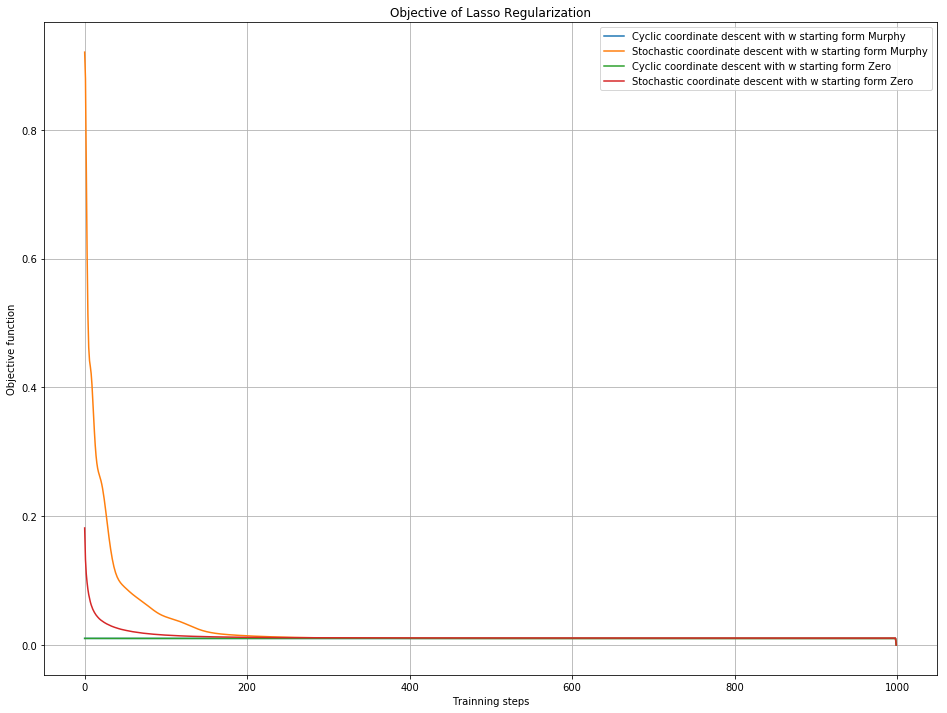

In [580]:
Finding_Lasso(X_train,y_train)

## 3.1.3

In [126]:
def Loss(X, y, w):
    residual = np.dot(X, w) - y
    empirical_risk = np.sum(residual**2)/X.shape[0]
    return empirical_risk

In [52]:
from numpy.linalg import inv
def SDL_Murphey(X, y, lambda_reg, num_iter=1000):
    (num_instances, num_features) = X.shape
    
    I = np.diag(np.ones(X.shape[1]))
    w = inv(np.dot(X.T,X)+ lambda_reg*I).dot(X.T).dot(y) 
    w_next = np.zeros(num_features)     

    l=list(range(num_features))     
    for i in range(num_iter):       

        np.random.shuffle(l)
        for j in l:  #stochastic  
            a = (2*X[:,j].T).dot(X[:,j])
            c = (2*X[:,j]).dot(y - X.dot(w.T) + w[j]*X[:,j])
            if a==0:
                w_next[j]=0
            else:
                w_next[j] = soft(c/a,lambda_reg/a)
            w[j] = w_next[j]
#         if (obj_hist[i+1]-obj_hist[i])<1e-8:
#             break 
            
    return w
    

In [60]:
def Finding_lambda(X_train,y_train,X_val,y_val,lambda_grid):
  
    Loss_hist = []
    for lambda_reg in lambda_grid: 
        w = SDL_Murphey(X_train, y_train, lambda_reg, num_iter=1000)
        Loss_hist.append(Loss(X_val, y_val, w))
    
    return Loss_hist

    

No handles with labels found to put in legend.


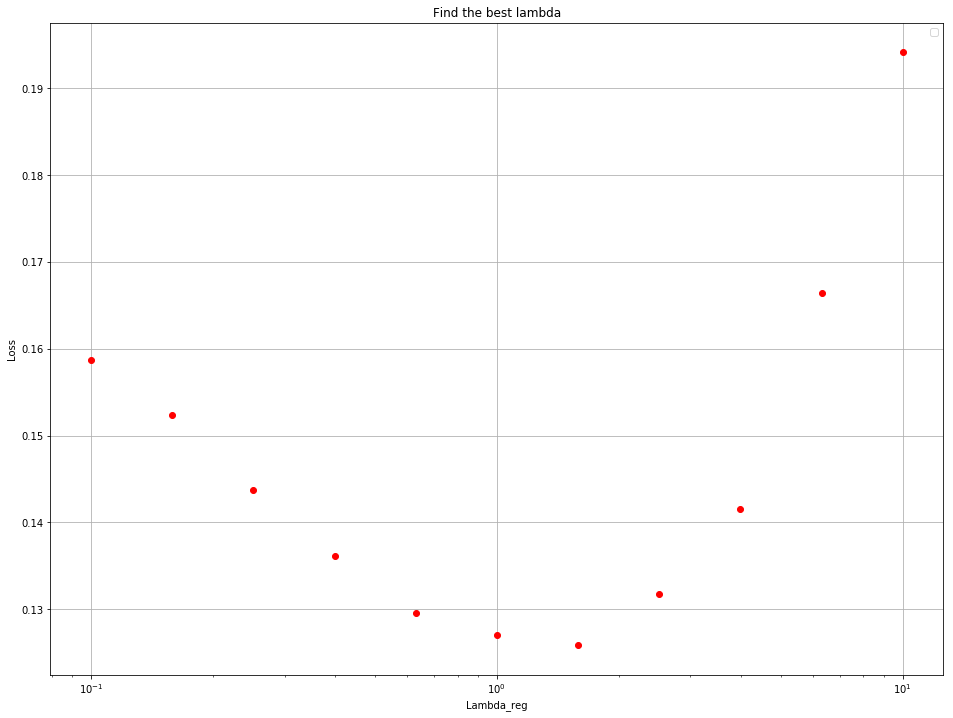

,mean_test_score,Lambda_list
0,0.158672,0.100000
1,0.152397,0.158489
2,0.143738,0.251189
3,0.136184,0.398107
4,0.129584,0.630957
5,0.127045,1.000000
6,0.125826,1.584893
7,0.131776,2.511886
8,0.141598,3.981072
9,0.166459,6.309573


In [80]:
lambda_grid = np.unique(10.**np.arange(-1,1.2,0.2))
Loss_hist = Finding_lambda(X_train,y_train, X_val,y_val, lambda_grid) 
df = pd.DataFrame() 
df['mean_test_score'] = Loss_hist 
df['Lambda_list'] = lambda_grid  
df

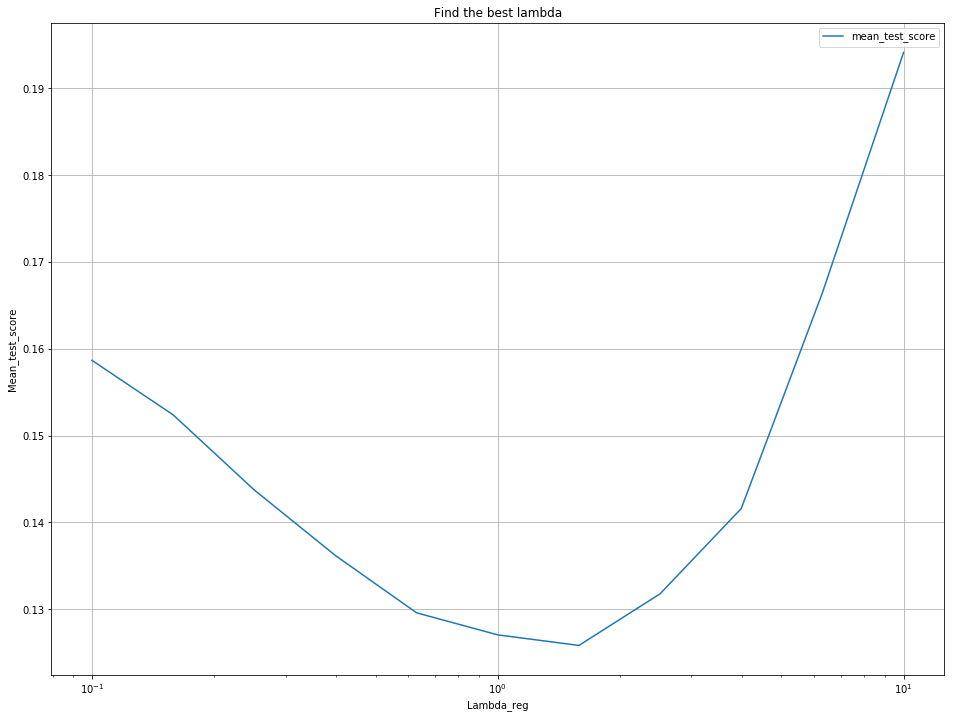

In [83]:
fig, ax = plt.subplots(figsize = (16, 12))
ax.semilogx(df["Lambda_list"], df["mean_test_score"])   
ax.set_xlabel("Lambda_reg")
ax.set_ylabel("Mean_test_score")
ax.set_title("Find the best lambda")
legend = ax.legend(loc='best')
legend.FontSize = 8
plt.grid(True)
plt.show() 


No handles with labels found to put in legend.


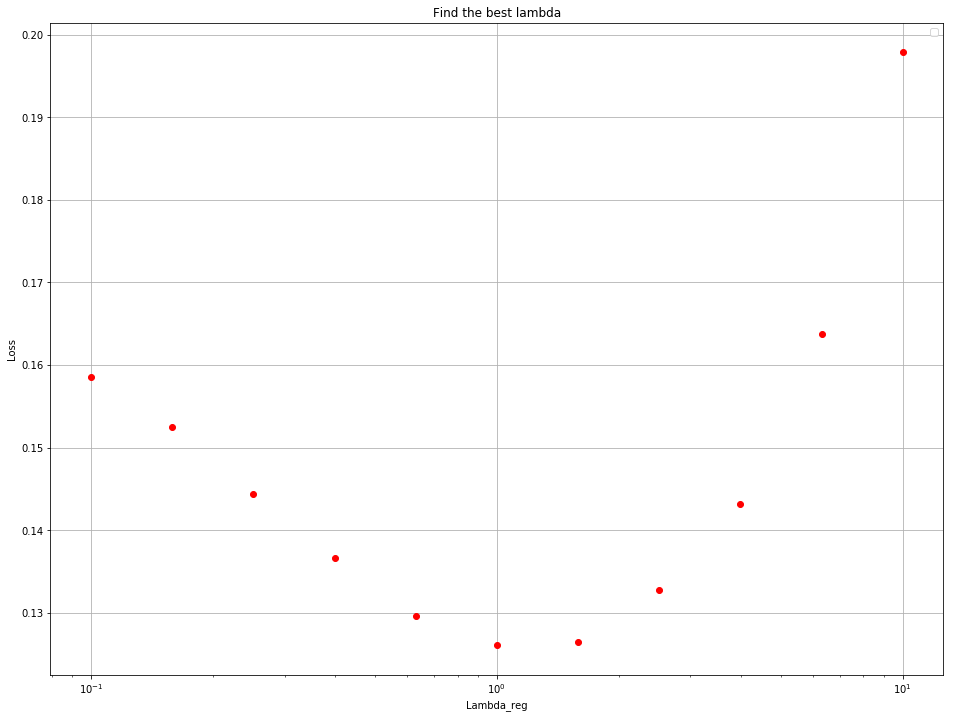

In [101]:
def plot_prediction_functions(x, pred_fns, X_val, y_val, legend_loc="best"):
    # Assumes pred_fns is a list of dicts, and each dict has a "name" key and a
    # "preds" key. The value corresponding to the "preds" key is an array of
    # predictions corresponding to the input vector x. x_train and y_train are
    # the input and output values for the training data
    fig, ax = plt.subplots(figsize = (12, 9))
    ax.set_xlabel('Input Space: [0,1)')
    ax.set_ylabel('Action/Outcome Space')
    ax.set_title("Prediction Functions")
    plt.scatter(X_val, y_val, label='Testing data')
    for i in range(len(pred_fns)):
        ax.plot(x, pred_fns[i]["preds"], label=pred_fns[i]["name"])
    legend = ax.legend(loc=legend_loc, shadow=True)
    return fig

pred_fns = []
x = np.sort(np.concatenate([np.arange(0,1,.001), x_val])) # 
name = "Target Parameter Values (i.e. Bayes Optimal)"
pred_fns.append({"name":name, "coefs":coefs_true, "preds": target_fn(x) })

l1regs = [1.584893]
X = featurize(x)
for l1reg in l1regs:
    name = "Lasso with L1Reg="+str(l1reg) 
    w = SDL_Murphey(X_val, y_val, l1reg)
    pred_fns.append({"name": name,
                     "coefs": w,
                     "preds": X.dot(w)})



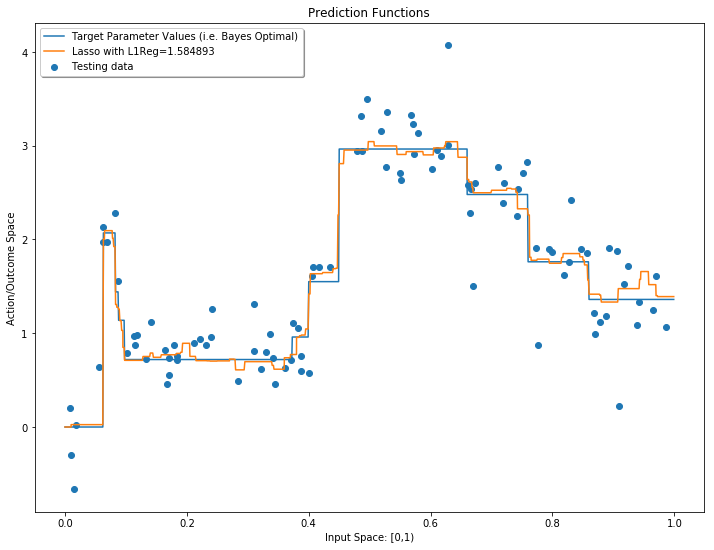

In [102]:
f = plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best")
plt.show()

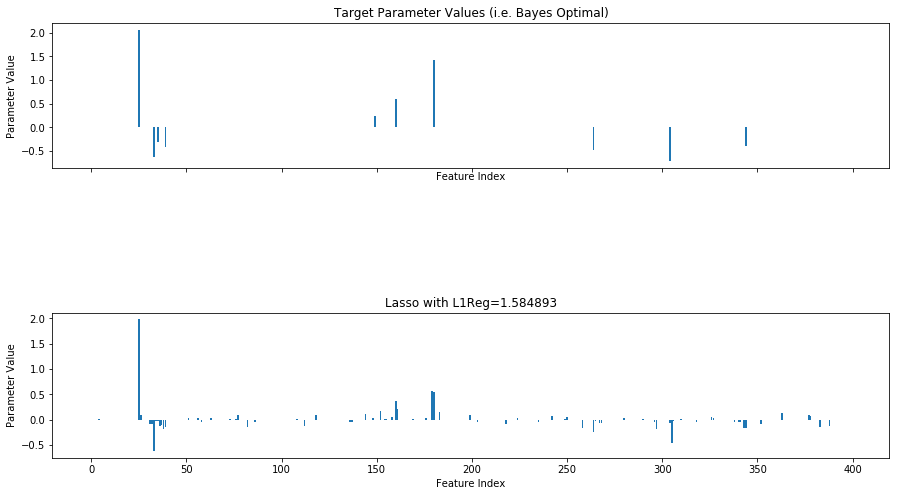

In [103]:
def compare_parameter_vectors(pred_fns):
    # Assumes pred_fns is a list of dicts, and each dict has a "name" key and a
    # "coefs" key
    fig, axs = plt.subplots(len(pred_fns),1, figsize = (15, 8),sharex=True)
    num_ftrs = len(pred_fns[0]["coefs"])
    for i in range(len(pred_fns)):
        title = pred_fns[i]["name"]
        coef_vals = pred_fns[i]["coefs"]
        axs[i].bar(range(num_ftrs), coef_vals)
        axs[i].set_xlabel('Feature Index')
        axs[i].set_ylabel('Parameter Value')
        axs[i].set_title(title)

    fig.subplots_adjust(hspace=1)
    return fig

f = compare_parameter_vectors(pred_fns)
plt.show()

## 3.1.4

In [124]:
def Homotopy_method(X, y, num_iter=1000):
    (num_instances, num_features) = X.shape
    
    from numpy.linalg import inv
    
    
    lambda_max = np.linalg.norm(2*X.T.dot(y), np.inf) #supernorm????
    I = np.diag(np.ones(X.shape[1]))
    w = inv(np.dot(X.T,X)+ lambda_max*I).dot(X.T).dot(y) 
    w_next = np.zeros(num_features)    
    
    objaver_hist = np.zeros(30)
    lambda_list = [lambda_max*(0.8**i) for i in range(30)]
    l=list(range(num_features)) 
    
    for l1 in range(30):
        lambda_reg = lambda_list[l1]
        for i in range(num_iter):       
            np.random.shuffle(l)
            for j in l:  #stochastic  
                a = (2*X[:,j].T).dot(X[:,j])
                c = (2*X[:,j]).dot(y - X.dot(w.T) + w[j]*X[:,j])
                if a==0:
                    w_next[j]=0
                else:
                    w_next[j] = soft(c/a,lambda_reg/a)
                w[j] = w_next[j]
    #         if (obj_hist[i+1]-obj_hist[i])<1e-8:
    #             break 

        objaver_hist[l1] = Lasso_obj(X, y, w.T, lambda_reg)/num_instances
            
    return objaver_hist, lambda_list

No handles with labels found to put in legend.


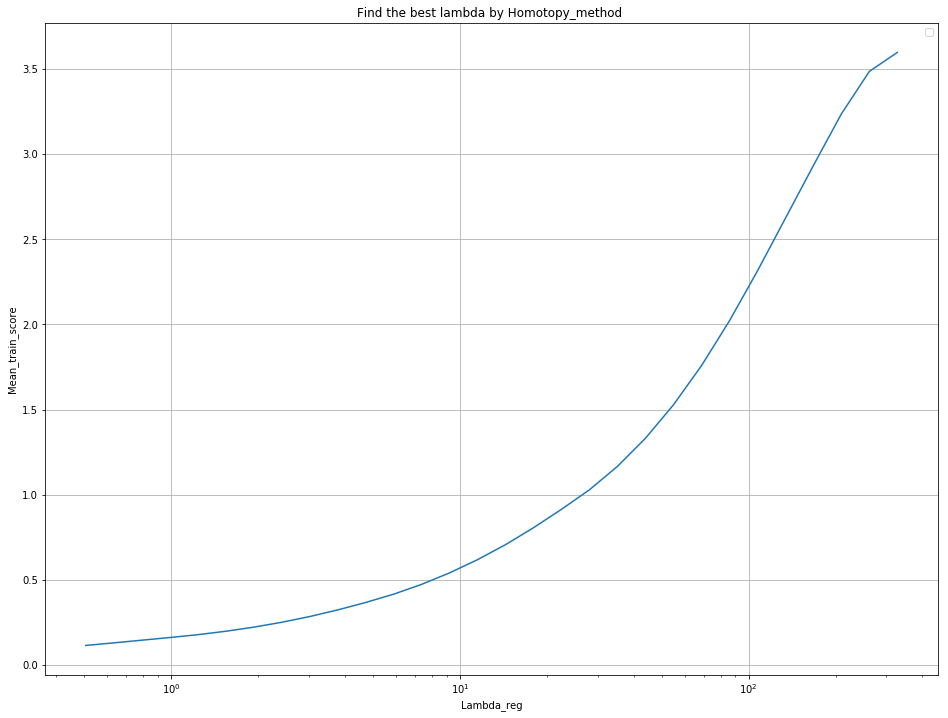

In [129]:
objaver_hist, lambda_list = Homotopy_method(X_train, y_train)

fig, ax = plt.subplots(figsize = (16, 12))
ax.semilogx(lambda_list, objaver_hist)   
ax.set_xlabel("Lambda_reg")
ax.set_ylabel("Mean_train_score")
ax.set_title("Find the best lambda by Homotopy_method ")
legend = ax.legend(loc='best')
legend.FontSize = 8
plt.grid(True)
plt.show() 

In [ ]:
        # print(objforplot_hist[i], i)
#         if i == 20:
#             assert(False)
#         # np.random.shuffle(l)